Creating blur dataset (Gaussian + Motion)...
Found and selected 350 source images to generate dataset.


Generating blur dataset: 100%|██████████| 350/350 [00:12<00:00, 28.02it/s]




Generated 1400 total samples.
Training samples: 896, Validation samples: 224, Test samples: 280
Normalizing images...
Training samples: 896, Validation samples: 224, Test samples: 280
Normalizing images...
Building and training model...
Building and training model...


c:\Users\kinshuk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - loss: 889.0818 - mae: 24.5305 - val_loss: 244.0037 - val_mae: 12.3814 - learning_rate: 0.0010
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 541ms/step - loss: 889.0818 - mae: 24.5305 - val_loss: 244.0037 - val_mae: 12.3814 - learning_rate: 0.0010
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - loss: 221.1670 - mae: 12.0043 - val_loss: 101.3554 - val_mae: 7.8699 - learning_rate: 0.0010
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - loss: 221.1670 - mae: 12.0043 - val_loss: 101.3554 - val_mae: 7.8699 - learning_rate: 0.0010
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 517ms/step - loss: 154.9137 - mae: 9.4105 - val_loss: 101.9767 - val_mae: 7.8904 - learning_rate: 0.0010
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 517ms/step - loss: 154.9137 - mae: 9.4105 - val_loss: 101.9767 - val_mae: 7.8904 - learning_rate: 0.0010
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 524ms/step - loss: 124.6041 - mae: 8.2045 - val_loss: 87.4386 - val_ma

Model saved to blur_detection_model_v2.h5
Evaluating model...
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step
Test MSE: 66.57
Test MAE: 6.01
Test MSE: 66.57
Test MAE: 6.01


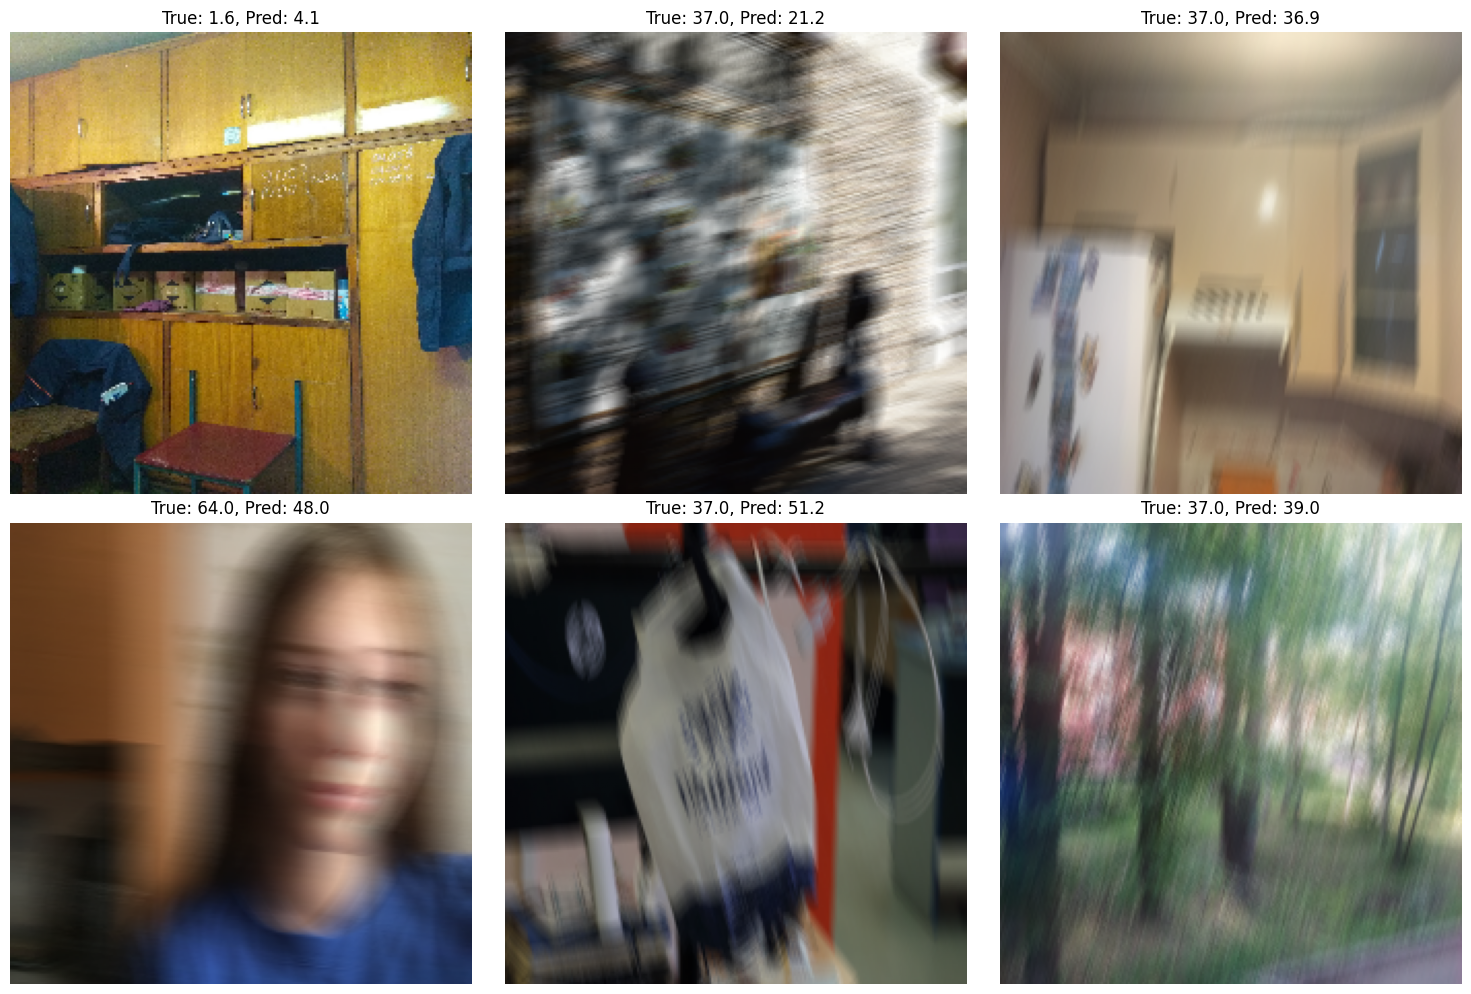

Comparing with traditional methods...


Calculating traditional scores: 100%|██████████| 280/280 [00:00<00:00, 1470.69it/s]



Laplacian correlation with true blur: 0.733
Tenengrad correlation with true blur: 0.568
Deep learning correlation with true blur: 0.929


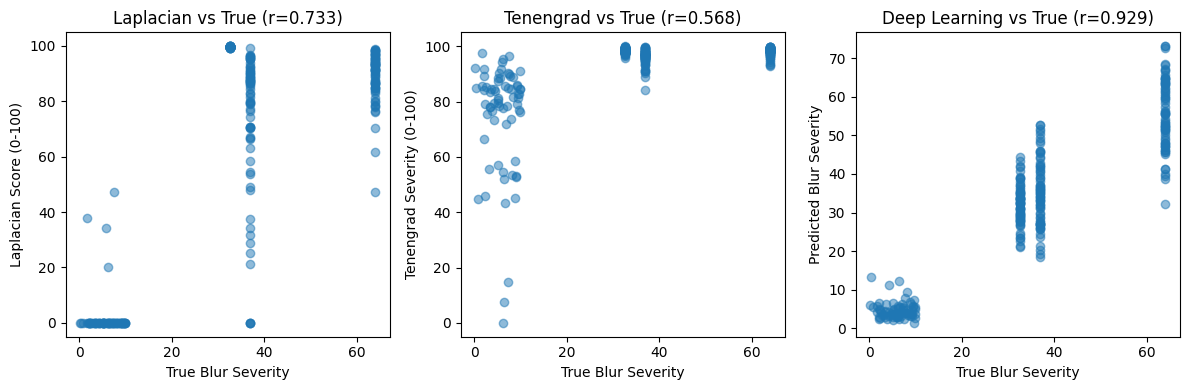

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.filters import gaussian
from skimage import img_as_float, img_as_ubyte

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- Helper function for Motion Blur ---
def apply_motion_blur(image, kernel_size, angle=0):
    """
    Applies motion blur to an image.

    Args:
        image: Input image (numpy array).
        kernel_size: Length of the motion blur kernel.
        angle: Angle of the motion blur in degrees.

    Returns:
        Motion blurred image (numpy array).
    """
    # Create the motion blur kernel
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2
    
    # Calculate endpoint coordinates based on angle
    dx = np.cos(np.radians(angle))
    dy = np.sin(np.radians(angle))
    
    # Draw a line in the kernel
    cv2.line(kernel, 
             (int(center - (kernel_size/2 - 1) * dx), int(center - (kernel_size/2 - 1) * dy)), 
             (int(center + (kernel_size/2 - 1) * dx), int(center + (kernel_size/2 - 1) * dy)), 
             1.0, 
             thickness=1)
             
    # Normalize the kernel
    kernel /= np.sum(kernel)
    
    # Apply the kernel to the image
    blurred_image = cv2.filter2D(image, -1, kernel)
    
    return blurred_image
# --------------------------------------


class BlurDatasetGenerator:
    """Class to generate a dataset of blurred images with severity labels."""
    
    # --- Keep __init__ and load_images as they are ---
    def __init__(self, image_dir, target_size=(224, 224), max_samples=1000):
        """
        Initialize the blur dataset generator.
        
        Args:
            image_dir: Directory containing training images
            target_size: Size to resize images to
            max_samples: Maximum number of samples to generate
        """
        self.image_dir = image_dir
        self.target_size = target_size
        self.max_samples = max_samples
        
    def load_images(self):
        """Load images from directory."""
        image_files = []
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        
        # Limit the number of images to load initially if max_samples is small
        # We generate 4 images per source image (1 original + 1 gaussian + 2 motion)
        max_source_images = self.max_samples 
        
        loaded_count = 0
        for root, dirs, files in os.walk(self.image_dir):
            if loaded_count >= max_source_images:
                 break
            for file in files:
                if loaded_count >= max_source_images:
                    break
                ext = os.path.splitext(file)[1].lower()
                if ext in valid_extensions:
                    image_files.append(os.path.join(root, file))
                    loaded_count += 1
                    
        print(f"Found and selected {len(image_files)} source images to generate dataset.")
        return image_files
    # ----------------------------------------------------

    def create_blur_dataset(self, image_files):
        """
        Create a dataset of images with varying blur levels (Gaussian and Motion).
        
        Returns:
            X: Image data with shape (n_samples, height, width, channels)
            y: Blur severity labels with shape (n_samples,)
        """
        X = []
        y = []
        
        generated_count = 0
        
        for img_path in tqdm(image_files, desc="Generating blur dataset"):
            if generated_count >= self.max_samples * 4 : # Check against total generated images
                 print(f"\nReached maximum sample limit ({self.max_samples * 4}). Stopping generation.")
                 break
                 
            try:
                # Load image
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}. Skipping.")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, self.target_size)
                
                # 1. Add original image with low blur score
                X.append(img)
                y.append(np.random.uniform(0, 10))  # Original images get a small blur score
                generated_count += 1
                if generated_count >= self.max_samples * 4: continue

                # 2. Add Gaussian blurred image (moderate blur)
                gauss_sigma = 3 # Example sigma
                img_float = img_as_float(img)
                gaussian_blurred_img = gaussian(img_float, sigma=gauss_sigma, channel_axis=-1)
                gaussian_blurred_img = img_as_ubyte(gaussian_blurred_img)
                # Map sigma to severity (similar scale to previous)
                gauss_severity = min(100, 10 + (gauss_sigma / 12) * 90) 
                X.append(gaussian_blurred_img)
                y.append(gauss_severity)
                generated_count += 1
                if generated_count >= self.max_samples * 4: continue

                # 3. Add Motion blurred image (moderate blur)
                motion_kernel_size1 = 15 # Example kernel size
                motion_angle1 = np.random.uniform(0, 180) # Random angle
                motion_blurred_img1 = apply_motion_blur(img, motion_kernel_size1, motion_angle1)
                # Map kernel size to severity (heuristic, adjust as needed)
                motion_severity1 = min(100, 10 + (motion_kernel_size1 / 50) * 90) 
                X.append(motion_blurred_img1)
                y.append(motion_severity1)
                generated_count += 1
                if generated_count >= self.max_samples * 4: continue

                # 4. Add Motion blurred image (higher blur)
                motion_kernel_size2 = 30 # Example kernel size
                motion_angle2 = np.random.uniform(0, 180) # Random angle
                motion_blurred_img2 = apply_motion_blur(img, motion_kernel_size2, motion_angle2)
                # Map kernel size to severity (heuristic, adjust as needed)
                motion_severity2 = min(100, 10 + (motion_kernel_size2 / 50) * 90) 
                X.append(motion_blurred_img2)
                y.append(motion_severity2)
                generated_count += 1
                # No need to check count here as it's the last item in the loop iteration
                
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue
        
        print(f"\nGenerated {len(X)} total samples.")
        return np.array(X), np.array(y)

# --- Keep BlurDetectionModel and TraditionalBlurDetector classes as they are ---
class BlurDetectionModel:
    """Class to build and train a blur detection model."""
    
    def __init__(self, input_shape=(224, 224, 3)):
        """
        Initialize the blur detection model.
        
        Args:
            input_shape: Input shape of images (height, width, channels)
        """
        self.input_shape = input_shape
        self.model = None
        
    def build_model(self):
        """Build a CNN model for blur detection."""
        # Use MobileNetV2 as base model for efficiency
        base_model = MobileNetV2(
            input_shape=self.input_shape,
            include_top=False,
            weights='imagenet'
        )
        
        # Freeze base model
        base_model.trainable = False
        
        # Build model
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1)  # Single output for blur severity (0-100)
        ])
        
        # Compile model
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        self.model = model
        return model
    
    def train(self, X_train, y_train, validation_data=None, epochs=10, batch_size=32):
        """
        Train the model.
        
        Args:
            X_train: Training images
            y_train: Training labels (blur severity)
            validation_data: (X_val, y_val) tuple for validation
            epochs: Number of training epochs
            batch_size: Batch size for training
            
        Returns:
            History object with training metrics
        """
        if self.model is None:
            self.build_model()
            
        # Data augmentation - Use a separate generator for validation if needed
        train_datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            # Removed preprocessing_function here, apply normalization before training
        )

        # Validation data generator (only normalization)
        val_datagen = ImageDataGenerator(
            # Removed preprocessing_function here
        )

        # Apply normalization outside the generator flow if not done already
        # Assuming X_train, X_val are already normalized (0-1) before calling train
        
        # Train the model
        history = self.model.fit(
            train_datagen.flow(X_train, y_train, batch_size=batch_size),
            epochs=epochs,
            validation_data=val_datagen.flow(validation_data[0], validation_data[1], batch_size=batch_size) if validation_data else None,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), # Monitor val_loss
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2) # Monitor val_loss
            ]
        )
        
        return history
    
    def save_model(self, filepath):
        """Save the model."""
        if self.model is not None:
            self.model.save(filepath)
            print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a saved model."""
        self.model = models.load_model(filepath)
        print(f"Model loaded from {filepath}")
        return self.model
    
    def predict_blur(self, image):
        """
        Predict blur severity for a single image.
        
        Args:
            image: Input image (height, width, channels) - Expected range 0-255
            
        Returns:
            Blur severity score (0-100)
        """
        if self.model is None:
            raise ValueError("Model not trained or loaded")
        
        # Preprocess image
        image = cv2.resize(image, (self.input_shape[0], self.input_shape[1]))
        image = image / 255.0  # Normalize
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        
        # Predict
        severity = self.model.predict(image)[0][0]
        
        # Clip to 0-100 range
        severity = max(0, min(100, severity))
        
        return severity

class TraditionalBlurDetector:
    """Class for traditional computer vision-based blur detection."""
    
    @staticmethod
    def variance_of_laplacian(image):
        """
        Compute the Laplacian of the image and then return the variance.
        A measure of image sharpness - low variance indicates blur.
        
        Args:
            image: Input image (grayscale or color, range 0-255)
            
        Returns:
            Variance of Laplacian
        """
        # Convert to grayscale if color image
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
            
        # Compute Laplacian
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        
        # Return variance
        return laplacian.var()
    
    @staticmethod
    def tenengrad_sharpness(image, ksize=3):
        """
        Compute the Tenengrad sharpness measure.
        Higher value indicates sharper image.
        
        Args:
            image: Input image (grayscale or color, range 0-255)
            ksize: Kernel size for Sobel operator
            
        Returns:
            Tenengrad sharpness value
        """
        # Convert to grayscale if color image
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
            
        # Compute gradients
        gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        
        # Compute gradient magnitude squared
        fm = gx**2 + gy**2 # Use squared value as per original Tenengrad definition
        
        # Return mean of squared magnitude
        return np.mean(fm) # Return mean, not sqrt(mean)
    
    @staticmethod
    def estimate_blur(image, threshold=1000.0): # Adjusted threshold based on typical Laplacian variance values
        """
        Estimate blur level using Laplacian variance.
        Maps the variance to a 0-100 scale (100 = sharp, 0 = blurry).
        
        Args:
            image: Input image (range 0-255)
            threshold: Approximate maximum expected Laplacian variance for normalization
            
        Returns:
            Blur score (0-100, lower = more blur)
        """
        variance = TraditionalBlurDetector.variance_of_laplacian(image)
        
        # Map variance to 0-100 scale (inverted, so 0 = max blur, 100 = no blur)
        # Use a non-linear mapping (like log) or clip carefully if variance exceeds threshold often
        blur_score = min(100.0, max(0.0, (variance / threshold) * 100.0))
        
        # Invert to match our convention (100 = max blur)
        blur_severity = 100.0 - blur_score
        
        return blur_severity, variance

# --- Keep visualize_results and main functions as they are, but ensure normalization is handled correctly ---

def visualize_results(X_test_normalized, y_test, y_pred, indices=None):
    """
    Visualize some test images with true and predicted blur severity.
    
    Args:
        X_test_normalized: Test images (normalized 0-1)
        y_test: True blur severity values
        y_pred: Predicted blur severity values
        indices: Indices of images to visualize (random if None)
    """
    if indices is None:
        indices = np.random.choice(len(X_test_normalized), min(6, len(X_test_normalized)), replace=False)
    
    num_plots = len(indices)
    cols = 3
    rows = (num_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1) # Ensure axes is 2D even for 1 row
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        # Display image (needs to be in 0-1 range for imshow if float)
        axes[i].imshow(X_test_normalized[idx]) 
        axes[i].set_title(f"True: {y_test[idx]:.1f}, Pred: {y_pred[idx]:.1f}")
        axes[i].axis('off')
        
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def main():
    """Main function to train and evaluate the blur detection model."""
    # Configuration
    IMAGE_DIR = r"E:\DL HACKATHON PROJECT\dataset\sharp"  # <<< --- UPDATE THIS PATH --- >>>
    TARGET_SIZE = (224, 224)
    MAX_SAMPLES = 500  # Limit source images for faster processing
    EPOCHS = 15 # Increased epochs slightly
    BATCH_SIZE = 32
    MODEL_PATH = "blur_detection_model_v2.h5" # New model name
    
    # Create dataset
    print("Creating blur dataset (Gaussian + Motion)...")
    generator = BlurDatasetGenerator(IMAGE_DIR, TARGET_SIZE, MAX_SAMPLES)
    image_files = generator.load_images()
    if not image_files:
        print(f"Error: No images found in {IMAGE_DIR}. Please check the path.")
        return
        
    X, y = generator.create_blur_dataset(image_files)
    
    if len(X) == 0:
        print("Error: Dataset generation failed. No samples created.")
        return
        
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=np.digitize(y, bins=np.linspace(0, 100, 11)) if len(np.unique(y)) > 10 else None # Stratify if enough classes
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=np.digitize(y_train, bins=np.linspace(0, 100, 11)) if len(np.unique(y_train)) > 10 else None # Stratify if enough classes
    )
    
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")
    
    # --- IMPORTANT: Normalize pixel values BEFORE feeding to the model/generator ---
    print("Normalizing images...")
    X_train_norm = X_train / 255.0
    X_val_norm = X_val / 255.0
    X_test_norm = X_test / 255.0
    # -----------------------------------------------------------------------------
    
    # Build and train model
    print("Building and training model...")
    blur_model = BlurDetectionModel(input_shape=(*TARGET_SIZE, 3)) # Renamed variable
    blur_model.build_model()
    history = blur_model.train(
        X_train_norm, y_train, # Use normalized data
        validation_data=(X_val_norm, y_val), # Use normalized data
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    
    # Save model
    blur_model.save_model(MODEL_PATH)
    
    # Evaluate model
    print("Evaluating model...")
    # Predict using the normalized test data
    y_pred = np.squeeze(blur_model.model.predict(X_test_norm)) 
    
    # Ensure predictions are within 0-100
    y_pred = np.clip(y_pred, 0, 100) 
    
    mse = np.mean((y_test - y_pred) ** 2)
    mae = np.mean(np.abs(y_test - y_pred))
    print(f"Test MSE: {mse:.2f}")
    print(f"Test MAE: {mae:.2f}")
    
    # Visualize results (using normalized test data for display)
    visualize_results(X_test_norm, y_test, y_pred)
    
    # Compare with traditional methods
    print("Comparing with traditional methods...")
    laplacian_scores = []
    tenengrad_scores = []
    
    # Use the original UNNORMALIZED test data for traditional methods
    for img in tqdm(X_test, desc="Calculating traditional scores"): 
        # Traditional methods expect 0-255 range
        lap_score, _ = TraditionalBlurDetector.estimate_blur(img)
        ten_score = TraditionalBlurDetector.tenengrad_sharpness(img)
        
        laplacian_scores.append(lap_score)
        tenengrad_scores.append(ten_score)
        
    laplacian_scores = np.array(laplacian_scores)
    tenengrad_scores = np.array(tenengrad_scores)
    
    # Normalize tenengrad scores to 0-100 (higher score = more blur)
    # Handle potential division by zero or NaN if all scores are the same
    min_ten = np.nanmin(tenengrad_scores)
    max_ten = np.nanmax(tenengrad_scores)
    if max_ten > min_ten:
         # Map higher sharpness (higher ten_score) to lower blur severity (0)
         # Map lower sharpness (lower ten_score) to higher blur severity (100)
        tenengrad_severity = 100.0 * (1.0 - (tenengrad_scores - min_ten) / (max_ten - min_ten))
    else:
        tenengrad_severity = np.zeros_like(tenengrad_scores) # Assign 0 if all scores are the same
        
    # Calculate correlations (handle potential NaNs)
    valid_indices = ~np.isnan(y_test) & ~np.isnan(laplacian_scores) & ~np.isnan(tenengrad_severity) & ~np.isnan(y_pred)
    
    if np.sum(valid_indices) > 1: # Need at least 2 points for correlation
        lap_corr = np.corrcoef(y_test[valid_indices], laplacian_scores[valid_indices])[0, 1]
        ten_corr = np.corrcoef(y_test[valid_indices], tenengrad_severity[valid_indices])[0, 1]
        dl_corr = np.corrcoef(y_test[valid_indices], y_pred[valid_indices])[0, 1]
        
        print(f"Laplacian correlation with true blur: {lap_corr:.3f}")
        print(f"Tenengrad correlation with true blur: {ten_corr:.3f}") # Correlation with severity
        print(f"Deep learning correlation with true blur: {dl_corr:.3f}")

        # Plot correlation between methods
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.scatter(y_test[valid_indices], laplacian_scores[valid_indices], alpha=0.5)
        plt.title(f"Laplacian vs True (r={lap_corr:.3f})")
        plt.xlabel("True Blur Severity")
        plt.ylabel("Laplacian Score (0-100)")
        
        plt.subplot(1, 3, 2)
        plt.scatter(y_test[valid_indices], tenengrad_severity[valid_indices], alpha=0.5)
        plt.title(f"Tenengrad vs True (r={ten_corr:.3f})")
        plt.xlabel("True Blur Severity")
        plt.ylabel("Tenengrad Severity (0-100)")
        
        plt.subplot(1, 3, 3)
        plt.scatter(y_test[valid_indices], y_pred[valid_indices], alpha=0.5)
        plt.title(f"Deep Learning vs True (r={dl_corr:.3f})")
        plt.xlabel("True Blur Severity")
        plt.ylabel("Predicted Blur Severity")
        
        plt.tight_layout()
        plt.show()
    else:
        print("Could not calculate correlations due to insufficient valid data points.")


if __name__ == "__main__":
    main()